This notebook reproduces our best submission from which scored 06.11 144.7793449 on the Kaggle public leaderboard. 
Note that the reading of files assumes this notebook is located in the same folder as data. 

In [1]:
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

c:\Users\elias\tdt4173\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Helper Functions

In [2]:
def plot_ts(y: pd.DataFrame, x:pd.DataFrame, start, end, feature, shareX: bool):
    """
    Plots all the y arrays, then all the x arrays.
    """
    fig, axs = plt.subplots(len(x)+len(y), 1, figsize=(15,10), sharex=shareX)
    i = 0
    for df in y:
        df[(df.index >= start) & (df.index <= end)].resample("H").mean().plot(ax=axs[i])
        i += 1
    
    for df in x:
        df[(df.index >= start) & (df.index <= end)].resample("H").mean()[feature].plot(ax=axs[i], label=feature, color="red")
        axs[i].legend()
        i += 1
    
            
def plot_ts1(y: pd.DataFrame, x:pd.DataFrame, start, end, feature, shareX: bool):
    """
    Plots the y and x values directly under each other for each location
    """
    
    if len(x) != len(y):
        print("Error: arrays 'y' and 'x' are different lengths. Please provide equal sized arrays.")
    else:
        fig, axs = plt.subplots(len(x)+len(y), 1, figsize=(15,10), sharex=shareX)
        i = 0
        for df_y, df_x in zip(y, x):
                df_y[(df_y.index >= start) & (df_y.index <= end)].resample("H").mean().plot(ax=axs[i])
                i += 1
                df_x[(df_x.index >= start) & (df_x.index <= end)].resample("H").mean()[feature].plot(ax=axs[i], label=feature, color="red")
                axs[i].legend()
                i += 1
  

def remove_constant_values(df, column_name, threshold):
    
    new_df = df.copy()

    # Find the consecutive constant rows
    consecutive_constants = new_df.groupby((new_df[column_name] != new_df[column_name].shift()).cumsum()).filter(lambda x: len(x) > threshold)

    # Filter out the consecutive constant rows from the original DataFrame
    filtered_df = new_df[~new_df.index.isin(consecutive_constants.index)]
    
    return filtered_df


# Location A


## Reading in files and indexing them on time


In [3]:
targets_a = TabularDataset('data/A/train_targets.parquet')
targets_a = targets_a.set_index('time')

In [4]:
X_train_observed_a = TabularDataset('data/A/X_train_observed.parquet')
X_train_observed_a = X_train_observed_a.set_index("date_forecast")

In [5]:
X_train_estimated_a = TabularDataset('data/A/X_train_estimated.parquet')
X_train_estimated_a = X_train_estimated_a.set_index("date_forecast")

In [6]:
X_test_estimated_a = TabularDataset('data/A/X_test_estimated.parquet')
X_test_estimated_a = X_test_estimated_a.set_index("date_forecast")

## Data Preprocessing

In [7]:
# removing rows where pv_measurment remains the same for more than 18 hours.
targets_a = remove_constant_values(targets_a, "pv_measurement", 18).dropna()

In [8]:
def create_features(df):
    new_df = df.copy()
    new_df['hour'] = new_df.index.hour
    new_df['month'] = new_df.index.month
    return new_df

In [9]:
### Adding more time based features to the datasets
X_train_observed_a = create_features(X_train_observed_a)

X_train_estimated_a = create_features(X_train_estimated_a)

X_test_estimated_a = create_features(X_test_estimated_a)

In [10]:
### Using only observed weather for training
# Join the y values into x-dataframes for training
train_a = pd.merge(X_train_observed_a, targets_a, left_index=True, right_index=True)

In [11]:
### Using estimated weather for validation and local testing
# Join the y values into x-dataframes 
test_a = pd.merge(X_train_estimated_a, targets_a, left_index=True, right_index=True)

In [12]:
# Remove 'date_calc' from test set and kaggle set
test_a.drop(columns=['date_calc'], inplace=True)
X_test_estimated_a.drop(columns=['date_calc'], inplace=True)

In [13]:
# List of column names to drop
columns_to_drop = [
    'snow_drift:idx',
    'elevation:m',                    
]

# Drop the specified columns from the DataFrames
train_a = train_a.drop(columns=columns_to_drop)

test_a = test_a.drop(columns=columns_to_drop)

X_test_estimated_a = X_test_estimated_a.drop(columns=columns_to_drop)

#### Some different functions for making the val/test split

In [14]:
def split(df):
    midpoint = len(df)//2
    front = df.iloc[:midpoint]
    end = df.iloc[midpoint:]
    return front, end

def split1000(df):
    front = df.iloc[:-1000]
    end = df.iloc[-1000:]
    return front, end

def sample_days_org(df, testfrac=0.6):
    # Extract unique dates from the datetime index as a list of date objects
    unique_dates = np.unique(df.index.date)
    
    combined_dates = []
    
    # Iterate through the unique dates and add all hours for each date
    for date in unique_dates:
        hours_for_date = df[df.index.date == date].index.time
        
        ## If you want all datapoints:
        combined_dates.extend([pd.Timestamp(date) + pd.DateOffset(hours=hour.hour) for hour in hours_for_date])
        
        ### Only where all 24 hours are present for a date:
        # if len(hours_for_date) == 24:
            # combined_dates.extend([pd.Timestamp(date) + pd.DateOffset(hours=hour.hour) for hour in hours_for_date])
    
    one = pd.Series(combined_dates).sample(frac=testfrac, random_state=35)
    two = pd.Series(combined_dates)[~pd.Series(combined_dates).isin(one)]
    
    test = df[df.index.isin(one)]
    val = df[df.index.isin(two)]
    
    return val, test

In [15]:
### Throw in some estimated weather to training as validation set, and the rest for testing
val_a, test_a = sample_days_org(test_a)

In [16]:
### Ensure a strict separation of validation and test set
def all_indices_different(df1, df2):
    # Check if all indices are different
    return df1.index.intersection(df2.index).empty

all_indices_different(val_a, test_a)

True

In [17]:
print(val_a.shape[0])
print(test_a.shape[0])

1510
2264


## Create our model

### Location A

In [18]:
predictor_a = TabularPredictor(label='pv_measurement', eval_metric='mean_absolute_error').fit(train_data=train_a,
                                                                                            tuning_data=val_a, 
                                                                                            presets='best_quality',
                                                                                            use_bag_holdout=True,
                                                                                             )

No path specified. Models will be saved in: "AutogluonModels\ag-20231112_124815\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20231112_124815\"
AutoGluon Version:  0.8.2
Python Version:     3.10.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   308.93 GB / 510.77 GB (60.5%)
Train Data Rows:    27741
Train Data Columns: 45
Tuning Data Rows:    1510
Tuning Data Columns: 45
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5733.42, 0.0, 720.95004, 1222.61515)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may speci

In [19]:
predictor_a.leaderboard(test_a, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-134.196519,-122.178630,33.882967,624.539605,1521.583808,0.000000,0.000000,0.234839,3,True,22
1,NeuralNetTorch_BAG_L2,-134.256125,-122.346399,33.384915,623.422807,1450.263038,0.333197,0.565850,73.407058,2,True,20
2,WeightedEnsemble_L2,-134.646359,-117.679257,13.479820,235.575521,345.541652,0.006588,0.000000,0.319348,2,True,12
3,NeuralNetTorch_BAG_L1,-136.348201,-118.652843,0.274281,0.324512,125.562953,0.274281,0.324512,125.562953,1,True,10
4,LightGBMXT_BAG_L2,-137.424897,-127.015391,33.168370,623.260706,1382.627752,0.116651,0.403749,5.771772,2,True,13
5,ExtraTreesMSE_BAG_L2,-138.618977,-128.327673,33.533199,624.407796,1389.403660,0.481481,1.550838,12.547679,2,True,17
6,LightGBM_BAG_L2,-138.688583,-130.286518,33.130451,623.047626,1381.627873,0.078733,0.190668,4.771893,2,True,14
7,XGBoost_BAG_L2,-139.675392,-129.992268,33.185276,623.066699,1384.577147,0.133558,0.209741,7.721167,2,True,19
8,CatBoost_BAG_L2,-139.841094,-129.922752,33.092749,622.930944,1402.105552,0.041031,0.073987,25.249572,2,True,16
9,RandomForestMSE_BAG_L2,-139.987379,-129.941947,33.549770,623.973755,1447.941911,0.498052,1.116797,71.085931,2,True,15


#### Feature importance, takes long time to run when using best quality

In [20]:

pd.set_option('display.max_rows', None)
# predictor_a.feature_importance(test_a,)

#### Using the weather forecast part of the training data as a dummy unseen test set

2023-04-28 11:00:00    3763.150508
2023-03-23 13:00:00    3491.387969
2023-04-28 10:00:00    2997.825898
2023-03-20 11:00:00    2920.089893
2023-03-23 14:00:00    2653.800957
Name: error, dtype: float64

Mean Absolute Error: 134.52731023566284
MAE for the last 1000 values: 217.21115709241585


<Axes: >

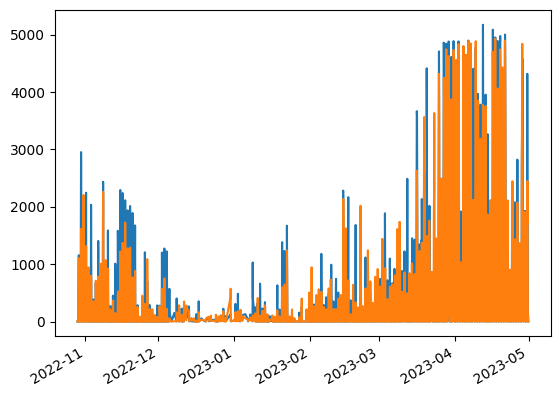

In [21]:
df = test_a.copy()
a_pred = predictor_a.predict(test_a)
a_pred = np.where(a_pred < 0.05, 0, a_pred)
df["prediction"] = a_pred

df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head())

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])

print(f"Mean Absolute Error: {mae}")

last_1000_values_df = df.tail(1000)

mae_last = mean_absolute_error(last_1000_values_df["pv_measurement"], last_1000_values_df["prediction"])
print("MAE for the last 1000 values:", mae_last)


df["pv_measurement"].plot()
df["prediction"].plot() 

## Predicting on the actual test set

In [22]:
### Location A
A_pred = predictor_a.predict(X_test_estimated_a)
A_pred_hourly = []

# just taking the value every whole hour
for i in range(0, len(A_pred), 4):
    A_pred_hourly.append(A_pred[i])

## Storing the predictions

In [23]:
predictions = np.array(A_pred_hourly)
# remove negative and small positive predictions
predictions = np.where(predictions < 0.05, 0, predictions)
ids = range(len(predictions))
df = pd.DataFrame({"id": ids, "prediction": predictions})

import os

base_filename = "autogluon_A.csv"

# Find the next available number to append to the filename
i = 1
while True:
    filename = os.path.join(f"{base_filename[:-4]}_{i}.csv")
    if not os.path.isfile(filename):
        break
    i += 1

# Save the DataFrame to the new filename
df.to_csv(filename, index=False)

# Location B

## Reading in files and indexing them on time

In [24]:
targets_b = TabularDataset('data/B/train_targets.parquet')
targets_b = targets_b.set_index("time")

Loaded data from: data/B/train_targets.parquet | Columns = 2 / 2 | Rows = 32848 -> 32848


In [25]:
X_train_observed_b = TabularDataset('data/B/X_train_observed.parquet')
X_train_observed_b = X_train_observed_b.set_index("date_forecast")

Loaded data from: data/B/X_train_observed.parquet | Columns = 46 / 46 | Rows = 116929 -> 116929


In [26]:
X_train_estimated_b = TabularDataset('data/B/X_train_estimated.parquet')
X_train_estimated_b = X_train_estimated_b.set_index("date_forecast")

Loaded data from: data/B/X_train_estimated.parquet | Columns = 47 / 47 | Rows = 17576 -> 17576


In [27]:
X_test_estimated_b = TabularDataset('data/B/X_test_estimated.parquet')
X_test_estimated_b = X_test_estimated_b.set_index("date_forecast")

Loaded data from: data/B/X_test_estimated.parquet | Columns = 47 / 47 | Rows = 2880 -> 2880


## Data Preprocessing

In [28]:
# removing rows where pv_measurment remains the same for more than 18 hours.
targets_b = remove_constant_values(targets_b, "pv_measurement", 18).dropna()

In [29]:
def create_features(df):
    new_df = df.copy()
    new_df['hour'] = new_df.index.hour
    new_df['dayofweek'] = new_df.index.dayofweek
    new_df['quarter'] = new_df.index.quarter
    new_df['weekofyear'] = new_df.index.isocalendar().week.astype(int)
    return new_df

In [30]:
### Adding more time based features to the datasets
X_train_observed_b = create_features(X_train_observed_b)

X_train_estimated_b = create_features(X_train_estimated_b)

X_test_estimated_b = create_features(X_test_estimated_b)

In [31]:
### Using only observed weather for training
# Join the y values into x-dataframes for training
train_b = pd.merge(X_train_observed_b, targets_b, left_index=True, right_index=True)

In [32]:
### Using only observed weather for training
# Join the y values into x-dataframes for training
test_b = pd.merge(X_train_estimated_b, targets_b, left_index=True, right_index=True)

In [33]:

# Remove 'date_calc' from test set and kaggle set
test_b.drop(columns=['date_calc'], inplace=True)
X_test_estimated_b.drop(columns=['date_calc'], inplace=True)

In [34]:
# List of column names to drop
columns_to_drop = [
  'elevation:m', 
  'snow_drift:idx',
    ]

# Drop the specified columns from the DataFrames
train_b = train_b.drop(columns=columns_to_drop)

test_b = test_b.drop(columns=columns_to_drop)

X_test_estimated_b = X_test_estimated_b.drop(columns=columns_to_drop)

In [35]:
def split(df):
    midpoint = len(df)//2
    front = df.iloc[:midpoint]
    end = df.iloc[midpoint:]
    return front, end

def split1000(df):
    midpoint = len(df)//2
    front = df.iloc[:-1000]
    end = df.iloc[-1000:]
    return front, end

def sample_days(df, testfrac=0.65):
    # Extract unique dates from the datetime index as a list of date objects
    unique_dates = np.unique(df.index.date)
    
    combined_dates = []
    
    # Iterate through the unique dates and add all hours for each date
    for date in unique_dates:
        hours_for_date = df[df.index.date == date].index.time
        
        ### If you want all datapoints:
        combined_dates.extend([pd.Timestamp(date) + pd.DateOffset(hours=hour.hour) for hour in hours_for_date])
        
        ### Only where all 24 hours are present for a date:
        # if len(hours_for_date) == 24:
        #     combined_dates.extend([pd.Timestamp(date) + pd.DateOffset(hours=hour.hour) for hour in hours_for_date])
    
    one = pd.Series(combined_dates).sample(frac=testfrac, random_state=35)
    two = pd.Series(combined_dates)[~pd.Series(combined_dates).isin(one)]
    
    test = df[df.index.isin(one)]
    val = df[df.index.isin(two)]
    
    return val, test


In [36]:
# Throw in some estimated weather to training as validation set, and the rest for testing
val_b, test_b = split(test_b)

In [37]:
val_b.shape[0]
test_b.shape[0]

1483

## Create our model

### Location B

In [38]:
predictor_b = TabularPredictor(label='pv_measurement', eval_metric='mean_absolute_error').fit(train_b,
                                                                                            tuning_data=val_b, 
                                                                                            presets='best_quality',
                                                                                            use_bag_holdout=True,
                                                                                            )

No path specified. Models will be saved in: "AutogluonModels\ag-20231112_131957\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20231112_131957\"
AutoGluon Version:  0.8.2
Python Version:     3.10.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   305.30 GB / 510.77 GB (59.8%)
Train Data Rows:    18880
Train Data Columns: 47
Tuning Data Rows:    1483
Tuning Data Columns: 47
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1152.3, 0.0, 137.34504, 233.90588)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify

In [39]:
predictor_b.leaderboard(test_b, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-30.739923,-4.925519,0.542396,1.179243,144.054082,0.014506,0.000000,0.207127,2,True,12
1,NeuralNetTorch_BAG_L1,-30.793319,-5.222282,0.198531,0.262235,115.313673,0.198531,0.262235,115.313673,1,True,10
2,WeightedEnsemble_L3,-30.930985,-5.164002,24.624806,473.683502,1451.747608,0.000000,0.000000,0.183183,3,True,22
3,NeuralNetTorch_BAG_L2,-30.961610,-5.188731,24.478025,473.358861,1418.732810,0.251048,0.333000,41.210433,2,True,20
4,LightGBMXT_BAG_L2,-31.365638,-5.228479,24.326937,473.316293,1382.987652,0.099959,0.290432,5.465275,2,True,13
5,CatBoost_BAG_L2,-31.496570,-5.538641,24.273799,473.060071,1404.888718,0.046822,0.034210,27.366341,2,True,16
6,LightGBM_BAG_L2,-31.828205,-5.582408,24.289491,473.215922,1382.369760,0.062513,0.190061,4.847383,2,True,14
7,ExtraTreesMSE_BAG_L2,-31.871166,-5.439681,24.588082,473.810505,1384.337616,0.361104,0.784644,6.815239,2,True,17
8,XGBoost_BAG_L2,-32.093277,-5.539678,24.352381,473.163017,1385.027474,0.125403,0.137156,7.505097,2,True,19
9,NeuralNetFastAI_BAG_L2,-32.106131,-6.233144,24.426369,473.430621,1409.872089,0.199392,0.404760,32.349712,2,True,18


#### Using the weather forecast part of the training data as a dummy unseen test set

2023-04-28 11:00:00    629.485558
2023-04-28 12:00:00    573.360850
2023-04-30 12:00:00    522.806352
2023-04-28 10:00:00    479.498965
2023-04-08 11:00:00    478.344025
Name: error, dtype: float64

Mean Absolute Error: 30.738645772198517
MAE for the last 1000 values: 36.58344269834296


<Axes: >

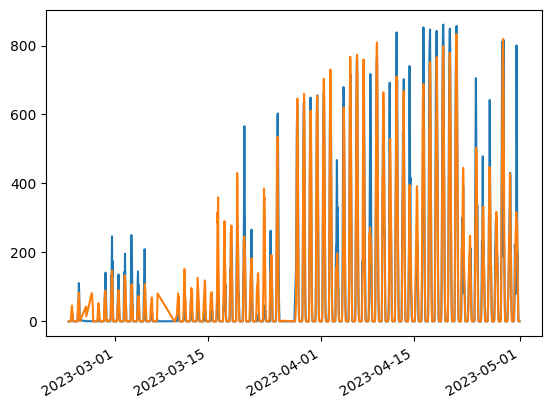

In [40]:
df = test_b.copy()
b_pred = predictor_b.predict(test_b)
b_pred = np.where(b_pred < 0.05, 0, b_pred)
df["prediction"] = b_pred

df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head())

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])

print(f"Mean Absolute Error: {mae}")

# Assuming df is your DataFrame
last_1000_values_df = df.tail(1000)

mae_last = mean_absolute_error(last_1000_values_df["pv_measurement"], last_1000_values_df["prediction"])
print("MAE for the last 1000 values:", mae_last)

df["pv_measurement"].plot()
df["prediction"].plot() 

## Predicting on the actual test set

In [41]:
### Location B
B_pred = predictor_b.predict(X_test_estimated_b)
B_pred_hourly = []

# just taking the value every whole hour
for i in range(0, len(B_pred), 4):
    B_pred_hourly.append(B_pred[i])

## Storing the predictions

In [42]:
predictions = np.array(B_pred_hourly)
# remove negative and small positive predictions
predictions = np.where(predictions < 0.05, 0, predictions)
ids = range(720, 720 + len(predictions))
df = pd.DataFrame({"id": ids, "prediction": predictions})

import os

base_filename = "autogluon_B.csv"

# Find the next available number to append to the filename
i = 1
while True:
    filename = os.path.join(f"{base_filename[:-4]}_{i}.csv")
    if not os.path.isfile(filename):
        break
    i += 1

# Save the DataFrame to the new filename
df.to_csv(filename, index=False)

# Location C

## Reading in files and indexing them on time

In [43]:

targets_c = TabularDataset('data/C/train_targets.parquet')
targets_c = targets_c.set_index("time")

Loaded data from: data/C/train_targets.parquet | Columns = 2 / 2 | Rows = 32155 -> 32155


In [44]:
X_train_observed_c = TabularDataset('data/C/X_train_observed.parquet')
X_train_observed_c = X_train_observed_c.set_index("date_forecast")

Loaded data from: data/C/X_train_observed.parquet | Columns = 46 / 46 | Rows = 116825 -> 116825


In [45]:
X_train_estimated_c = TabularDataset('data/C/X_train_estimated.parquet')
X_train_estimated_c = X_train_estimated_c.set_index("date_forecast")

Loaded data from: data/C/X_train_estimated.parquet | Columns = 47 / 47 | Rows = 17576 -> 17576


In [46]:
X_test_estimated_c = TabularDataset('data/C/X_test_estimated.parquet')
X_test_estimated_c = X_test_estimated_c.set_index("date_forecast")

Loaded data from: data/C/X_test_estimated.parquet | Columns = 47 / 47 | Rows = 2880 -> 2880


## Data Preprocessing

In [47]:
# removing rows where pv_measurment remains the same for more than 18 hours.
targets_c = remove_constant_values(targets_c, "pv_measurement", 18).dropna()

In [48]:
def create_features(df):
    new_df = df.copy()
    new_df['dayofyear'] = new_df.index.dayofyear
    new_df['weekofyear'] = new_df.index.isocalendar().week.astype(int)
    return new_df

In [49]:
### Adding more time based features to the datasets
X_train_observed_c = create_features(X_train_observed_c)

X_train_estimated_c = create_features(X_train_estimated_c)

X_test_estimated_c = create_features(X_test_estimated_c)

In [50]:
### Using only observed weather for training
# Join the y values into x-dataframes for training
train_c = pd.merge(X_train_observed_c, targets_c, left_index=True, right_index=True)

In [51]:
### Using only observed weather for training
# Join the y values into x-dataframes for training
test_c = pd.merge(X_train_estimated_c, targets_c, left_index=True, right_index=True)

In [52]:

# Remove 'date_calc' from test set and kaggle set
test_c.drop(columns=['date_calc'], inplace=True)
X_test_estimated_c.drop(columns=['date_calc'], inplace=True)

In [53]:
# List of column names to drop
columns_to_drop = [

 'air_density_2m:kgm3', 
 'ceiling_height_agl:m', 
 'cloud_base_agl:m', 
 'dew_or_rime:idx',
 'effective_cloud_cover:p',
 'elevation:m',
 'fresh_snow_1h:cm', 
 'fresh_snow_24h:cm', 
 'is_day:idx',
 'is_in_shadow:idx',
 'msl_pressure:hPa',
 'precip_5min:mm', 
 'precip_type_5min:idx',
 'pressure_100m:hPa',
 'pressure_50m:hPa', 
 'prob_rime:p', 
 'rain_water:kgm2', 
 'relative_humidity_1000hPa:p', 
 'sfc_pressure:hPa',
 'snow_density:kgm3',
 'snow_drift:idx', 
 'snow_water:kgm2',
 'sun_azimuth:d',
 'super_cooled_liquid_water:kgm2',
 't_1000hPa:K', 
 'total_cloud_cover:p',
 'visibility:m', 
 'wind_speed_10m:ms',
 'wind_speed_u_10m:ms',
 'wind_speed_v_10m:ms'


]

# Drop the specified columns from the DataFrames
train_c = train_c.drop(columns=columns_to_drop)

test_c = test_c.drop(columns=columns_to_drop)

X_test_estimated_c = X_test_estimated_c.drop(columns=columns_to_drop)

In [54]:
def split(df):
    midpoint = len(df)//2
    front = df.iloc[:midpoint]
    end = df.iloc[midpoint:]
    return front, end

def split1000(df):
    midpoint = len(df)//2
    front = df.iloc[:-1000]
    end = df.iloc[-1000:]
    return front, end

def sample_days(df, testfrac=0.55):
    # Extract unique dates from the datetime index as a list of date objects
    unique_dates = np.unique(df.index.date)
    
    combined_dates = []
    
    # Iterate through the unique dates and add all hours for each date
    for date in unique_dates:
        hours_for_date = df[df.index.date == date].index.time
        
        ### If you want all datapoints:
        # combined_dates.extend([pd.Timestamp(date) + pd.DateOffset(hours=hour.hour) for hour in hours_for_date])
        
        ### Only where all 24 hours are present for a date:
        if len(hours_for_date) == 24:
            combined_dates.extend([pd.Timestamp(date) + pd.DateOffset(hours=hour.hour) for hour in hours_for_date])
    
    one = pd.Series(combined_dates).sample(frac=testfrac, random_state=35)
    two = pd.Series(combined_dates)[~pd.Series(combined_dates).isin(one)]
    
    test = df[df.index.isin(one)]
    val = df[df.index.isin(two)]
    
    return val, test

In [55]:
# Throw in some estimated weather to training as validation set, and the rest for testing
val_c, test_c = split(test_c)

## Create our model

### Location C

In [56]:
predictor_c = TabularPredictor(label='pv_measurement', eval_metric='mean_absolute_error').fit(train_c,
                                                                                            tuning_data=val_c, 
                                                                                            )

No path specified. Models will be saved in: "AutogluonModels\ag-20231112_134852\"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20231112_134852\"
AutoGluon Version:  0.8.2
Python Version:     3.10.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   302.13 GB / 510.77 GB (59.2%)
Train Data Rows:    16041
Train Data Columns: 17
Tuning Data Rows:    1166
Tuning Data Columns: 17
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (999.6, 0.0, 118.71007, 195.02142)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fittin

In [57]:
predictor_c.leaderboard(test_c, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetTorch,-34.858738,-6.171607,0.020234,0.015645,8.400505,0.020234,0.015645,8.400505,1,True,10
1,WeightedEnsemble_L2,-35.244255,-5.753446,0.104633,0.044866,9.186701,0.016623,0.000000,0.216741,2,True,12
2,CatBoost,-38.794289,-7.737143,0.019394,0.000000,1.577648,0.019394,0.000000,1.577648,1,True,6
3,LightGBMXT,-39.838709,-7.308401,0.013862,0.000000,0.558007,0.013862,0.000000,0.558007,1,True,3
4,XGBoost,-44.189343,-7.703783,0.017612,0.003000,0.552281,0.017612,0.003000,0.552281,1,True,9
5,LightGBM,-45.021563,-8.165778,0.016715,0.016066,0.537824,0.016715,0.016066,0.537824,1,True,4
6,KNeighborsUnif,-48.545300,-9.086432,0.053914,0.029221,0.011448,0.053914,0.029221,0.011448,1,True,1
7,NeuralNetFastAI,-49.022423,-8.918217,0.066709,0.016699,12.582267,0.066709,0.016699,12.582267,1,True,8
8,KNeighborsDist,-49.217221,-9.262500,0.031340,0.035651,0.000000,0.031340,0.035651,0.000000,1,True,2
9,RandomForestMSE,-49.604333,-8.549842,0.250077,0.056392,7.529274,0.250077,0.056392,7.529274,1,True,5


In [58]:
predictor_c.feature_importance(test_c, )

Computing feature importance via permutation shuffling for 17 features using 1166 rows with 5 shuffle sets...
	7.05s	= Expected runtime (1.41s per shuffle set)
	3.18s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
direct_rad:W,20.258052,1.404430,0.000003,5,23.149793,17.366310
direct_rad_1h:J,19.485752,1.421385,0.000003,5,22.412403,16.559101
clear_sky_energy_1h:J,19.075803,1.188612,0.000002,5,21.523171,16.628435
clear_sky_rad:W,14.722840,1.298318,0.000007,5,17.396093,12.049586
diffuse_rad:W,10.981188,1.105888,0.000012,5,13.258225,8.704150
diffuse_rad_1h:J,10.812217,0.606425,0.000001,5,12.060854,9.563580
fresh_snow_12h:cm,5.025489,1.167968,0.000326,5,7.430353,2.620626
sun_elevation:d,4.763054,0.653133,0.000041,5,6.107863,3.418244
fresh_snow_3h:cm,3.110865,0.843306,0.000589,5,4.847245,1.374486
dew_point_2m:K,2.749957,0.353137,0.000032,5,3.477072,2.022842


#### Using the weather forecast part of the training data as a dummy unseen test set

2023-04-14 11:00:00    404.959079
2023-04-28 09:00:00    392.132656
2023-03-27 12:00:00    346.471726
2023-03-27 11:00:00    317.606681
2023-03-27 10:00:00    308.530646
Name: error, dtype: float64

Mean Absolute Error: 35.24333624299315
MAE for the last 1000 values: 38.38122172056154


<Axes: >

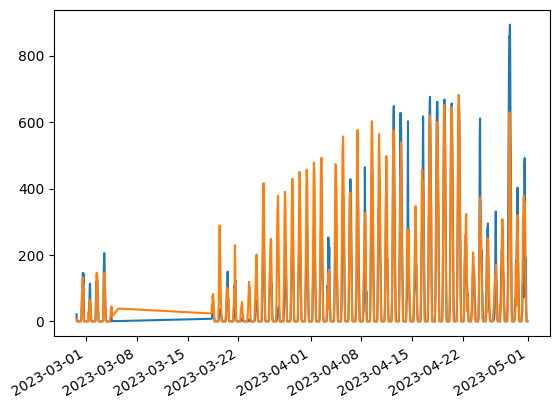

In [59]:
df = test_c.copy()
c_pred = predictor_c.predict(test_c)
c_pred = np.where(c_pred < 0.05, 0, c_pred)
df["prediction"] = c_pred

df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head())

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])

print(f"Mean Absolute Error: {mae}")

# Assuming df is your DataFrame
last_1000_values_df = df.tail(1000)

mae_last = mean_absolute_error(last_1000_values_df["pv_measurement"], last_1000_values_df["prediction"])
print("MAE for the last 1000 values:", mae_last)

df["pv_measurement"].plot()
df["prediction"].plot() 

## Predicting on the actual test set

In [60]:
### Location C
C_pred = predictor_c.predict(X_test_estimated_c)
C_pred_hourly = []

# just taking the value every whole hour
for i in range(0, len(C_pred), 4):
    C_pred_hourly.append(C_pred[i])  

## Storing the predictions

In [61]:
predictions = np.array(C_pred_hourly)
# remove negative and small positive predictions
predictions = np.where(predictions < 0.05, 0, predictions)
ids = range(1440, 1440 + len(predictions))
df = pd.DataFrame({"id": ids, "prediction": predictions})

import os

base_filename = "autogluon_C.csv"

# Find the next available number to append to the filename
i = 1
while True:
    filename = os.path.join(f"{base_filename[:-4]}_{i}.csv")
    if not os.path.isfile(filename):
        break
    i += 1

# Save the DataFrame to the new filename
df.to_csv(filename, index=False)

# Concatinating the predictions

In [62]:
a = pd.read_csv('autogluon_A_1.csv')
b = pd.read_csv('autogluon_B_1.csv')
c = pd.read_csv('autogluon_C_1.csv')

submission = pd.concat([a,b,c])
submission.to_csv('submission.csv', index=False)